In [1]:
import pickle, gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob, os
import re, ast
import itertools
import seaborn as sns
from matplotlib import rcParams
from qiskit.visualization import plot_histogram
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from seaborn import set_theme
from matplotlib import style

rcParams.update({'figure.autolayout': True})
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
#rc('text', usetex=True)
rcParams['text.usetex'] = True

In [2]:

####### original version
# # Compute the new QVF for the whole circuit, as well as for each available qubit
def compute_QVF_michelson_contrast_single_injection(df, circuit_name, phi, theta):
    dfFilter = df[(df.circuit_name==circuit_name) & (df.first_phi==phi) & (df.first_theta==theta)]
    #print('computing QVF for',circuit_name)
    #print(dfFilter)
    QVF = {}
    QVF['QVF_circuit'] = dfFilter['QVF'].mean()
    #print(QVF['QVF_circuit'],sum(dfFilter['success']),len(dfFilter['success']))
    #print('-----------')
    
    qubits = set(dfFilter['first_qubit_injected'])    
    for q in qubits:
        QVF['QVF_qubit_'+str(q)] = dfFilter[dfFilter.first_qubit_injected==q]['QVF'].mean()
    #QVF['gold_ok'] = dfFilter['gold_success'][0]
    return QVF

#######multi-injection version
# Compute the new QVF for the whole circuit, as well as for each available qubit
def compute_QVF_michelson_contrast_double_injection(df, circuit_name, phi_0, theta_0, phi_1, theta_1):
    dfFilter = df[(df.circuit_name == circuit_name) & (df.first_phi == phi_0) & (df.first_theta == theta_0)& (df.second_phi == phi_1) & (df.second_theta == theta_1)]
    #print('computing QVF for',circuit_name)
    #print(dfFilter)
    QVF = {}
    QVF['QVF_circuit'] = dfFilter['QVF'].mean()
    #print(QVF['QVF_circuit'],sum(dfFilter['success']),len(dfFilter['success']))
    #print('-----------')

    qubits = set(dfFilter['first_qubit_injected'])
    for q in qubits:
        QVF['QVF_qubit_' +
            str(q)] = dfFilter[dfFilter.first_qubit_injected == q]['QVF'].mean()
    #QVF['gold_ok'] = dfFilter['gold_success'][0]
    return QVF



def QVF_michelson_contrast(gold_bitstring, answer, shots):    
    # Sort the answer, position 0 has the highest bitstring, position 1 the second highest
    answer_sorted = sorted(answer, key=answer.get, reverse=True)
    
    # If gold bitstring is not in answer, percentage is zero
    if gold_bitstring not in answer:
        good_percent = 0
    else:
        good_percent = answer[gold_bitstring]/shots
        
    if answer_sorted[0] == gold_bitstring: # gold bitstring has the highest count (max)
        # next bitstring is the second highest
        next_percent = answer[answer_sorted[1]]/shots 
        next_bitstring = answer_sorted[1]
    else: # gold bitstring has NOT the highest count (not max)
        next_percent = answer[answer_sorted[0]]/shots 
        next_bitstring = answer_sorted[0]
    qvf = (good_percent - next_percent) / (good_percent + next_percent)    
    return 1 - (qvf+1)/2, next_bitstring
    
# Read pickled data and store results in a dataframe
def build_DF_newQVF(data):
    results = []
    shots = 1024
    gold_bitstring = max(data['output_gold_noise'], key=data['output_gold_noise'].get)#check
    original_gold_percentage = data['output_gold_noise'][gold_bitstring]/shots

    for i, answer in enumerate(data['output_injections_noise']):
        qvf, next_bitstring = QVF_michelson_contrast(gold_bitstring, answer, shots)
        max_key = max(answer, key=answer.get)
        output_percentage = answer[max_key]/shots
        next_bitstring_percentage = answer[next_bitstring]/shots
        if gold_bitstring not in answer:
            gold_percentage = 0
        else:
            gold_percentage = answer[gold_bitstring]/shots
        result = {'gold_bitstring':gold_bitstring
                , 'gold_count_percentage':gold_percentage
                , 'original_gold_count_percentage':original_gold_percentage
                , 'next_bitstring': next_bitstring
                , 'next_bitstring_percentage': next_bitstring_percentage
                , 'QVF':qvf
                , 'first_qubit_injected':data['circuits_injections'][i].metadata['first_qubit']                
                , 'first_phi':data['circuits_injections'][i].metadata['first_phi']
                , 'first_theta':data['circuits_injections'][i].metadata['first_theta']
                , 'second_qubit_injected':data['circuits_injections'][i].metadata['second_qubit']                
                , 'second_phi':data['circuits_injections'][i].metadata['second_phi']
                , 'second_theta':data['circuits_injections'][i].metadata['second_theta']
                #, 'gate_injected':data['circuits_injections'][i].metadata['gate_inserted']
                #, 'lambda':data['circuits_injections'][i].metadata['lambda']
                , 'circuit_name':data['name']
                }
        #first_qubit, first_theta, first_phi, second_qubit, second_theta, second_phi
        results.append(result)
    return pd.DataFrame(results)


In [3]:
files_to_process = [
'../results/double_fi_BV_4qubits.p.gz', 
]
# read all data and insert it into one dataframe
df_newQVF = pd.DataFrame()
for filename in files_to_process:
    data = pickle.load(gzip.open(filename, 'r'))
    
    for d in data:
        df_newQVF = pd.concat([df_newQVF, build_DF_newQVF(d)], ignore_index=True)
    del data

In [ ]:
df_newQVF

In [ ]:
#####################################################################################
#Daniel original

In [ ]:
# Get available circuits and parameters used for injection (phi and theta)
phi_list = list(set(df_newQVF.first_phi))
phi_list.sort(reverse=True)
theta_list = list(set(df_newQVF.first_theta))
theta_list.sort()
circuits = list(set(df_newQVF.circuit_name))
circuits.sort()

In [7]:
results = []
for circuit in circuits:
    for phi in phi_list:
        for theta in theta_list:
            qvf = compute_QVF_michelson_contrast_single_injection(df_newQVF, circuit, phi, theta)
            qvf['circuit_name'] = circuit
            qvf['first_phi'] = phi
            qvf['first_theta'] = theta
            #qvf['threshold'] = threshold
            results.append(qvf)

new_qvfDF_noise = pd.DataFrame(results)
new_qvfDF_noise = new_qvfDF_noise[sorted(list(new_qvfDF_noise.columns))]
new_qvfDF_noise
#compute_QVF_michelson_contrast

,QVF_circuit,QVF_qubit_0,QVF_qubit_1,QVF_qubit_2,QVF_qubit_3,circuit_name,first_phi,first_theta
0,0.742237,0.661715,0.809052,0.663208,0.806650,Bernstein-Vazirani_4,3.141593,0.000000
1,0.734889,0.659591,0.799110,0.658511,0.796325,Bernstein-Vazirani_4,3.141593,0.261799
2,0.716438,0.651965,0.771497,0.649307,0.770316,Bernstein-Vazirani_4,3.141593,0.523599
3,0.686896,0.642255,0.735526,0.635173,0.724192,Bernstein-Vazirani_4,3.141593,0.785398
4,0.647488,0.626052,0.683347,0.615274,0.666240,Bernstein-Vazirani_4,3.141593,1.047198
...,...,...,...,...,...,...,...,...
164,0.699264,0.744041,0.745508,0.742674,0.632574,Bernstein-Vazirani_4,0.000000,2.094395
165,0.785318,0.841371,0.845557,0.831398,0.707150,Bernstein-Vazirani_4,0.000000,2.356194
166,0.843903,0.907310,0.915649,0.897061,0.753352,Bernstein-Vazirani_4,0.000000,2.617994
167,0.879579,0.947212,0.955598,0.936785,0.782807,Bernstein-Vazirani_4,0.000000,2.879793


In [ ]:
#### Without multiplication sign 'x'
# theta_list_tex = ['0', '$\\frac{\pi}{12}$', '$\\frac{\pi}{6}$', '$\\frac{\pi}{4}$', '$\\frac{\pi}{3}$', '$\\frac{5\pi}{12}$', '$\\frac{\pi}{2}$', '$\\frac{7\pi}{12}$'
#               , '$\\frac{4\pi}{6}$', '$\\frac{3\pi}{4}$', '$\\frac{5\pi}{6}$', '$\\frac{11\pi}{12}$', '$\pi$']
# phi_list_tex = ['$\\frac{23\pi}{12}$', '$\\frac{11\pi}{6}$', '$\\frac{7\pi}{4}$', '$\\frac{5\pi}{3}$', '$\\frac{19\pi}{12}$'
#             , '$\\frac{6\pi}{4}$', '$\\frac{17\pi}{12}$', '$\\frac{4\pi}{3}$', '$\\frac{5\pi}{4}$', '$\\frac{7\pi}{6}$'
#             , '$\\frac{13\pi}{12}$', '$\pi$', '$\\frac{11\pi}{12}$', '$\\frac{5\pi}{6}$',  '$\\frac{3\pi}{4}$'  
#             , '$\\frac{4\pi}{6}$', '$\\frac{7\pi}{12}$', '$\\frac{\pi}{2}$', '$\\frac{5\pi}{12}$', '$\\frac{\pi}{3}$', '$\\frac{\pi}{4}$'
#             , '$\\frac{\pi}{6}$', '$\\frac{\pi}{12}$', '0']

##considering all possible phi angles
# theta_list_tex = ['0', '', '', '$\\frac{\pi}{4}$', '', '', '$\\frac{\pi}{2}$', ''
#                 , '', '$\\frac{3\pi}{4}$', '', '', '$\pi$']
# phi_list_tex = ['', '', '$\\frac{7\pi}{4}$', '', ''
#             , '$\\frac{6\pi}{4}$', '', '', '$\\frac{5\pi}{4}$', ''
#             , '', '$\pi$', '', '',  '$\\frac{3\pi}{4}$'  
#             , '', '', '$\\frac{\pi}{2}$', '', '', '$\\frac{\pi}{4}$'
#             , '', '', '0']

##considering only phi angles up to pi
theta_list_tex = ['0', '', '', '$\\frac{\pi}{4}$', '', '', '$\\frac{\pi}{2}$', ''
                , '', '$\\frac{3\pi}{4}$', '', '', '$\pi$']
phi_list_tex = ['$\pi$', '', '',  '$\\frac{3\pi}{4}$'  
            , '', '', '$\\frac{\pi}{2}$', '', '', '$\\frac{\pi}{4}$'
            , '', '', '0']



dirHeatmapPlots = '../plots/double_FI/heatmaps/'
dirHistPlots = '../plots/double_FI/histograms/'
if not os.path.exists(dirHeatmapPlots):
    os.makedirs(dirHeatmapPlots)
if not os.path.exists(dirHistPlots):
    os.makedirs(dirHistPlots)    
            
for circuit in circuits:
    # get a list of qubit columns (circuit may have different number of qubits now)
    colNames = new_qvfDF_noise[new_qvfDF_noise['circuit_name']==circuit].dropna(axis=1).columns    
    QVF_list= ['QVF_circuit']
    QVF_list.extend( [x for x in colNames if re.search('QVF_qubit_.*',x)] ) # uncomment this line to include individual qubit analysis
    
    for qvf_idx in QVF_list:
        qvf_tmp = new_qvfDF_noise[new_qvfDF_noise['circuit_name']==circuit]
        qvf_tmp = qvf_tmp.pivot('first_phi', 'first_theta', qvf_idx)
        qvf_tmp.columns.name = '$\\theta$ shift'
        qvf_tmp.index.name = '$\\phi$ shift'
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        param={'label': 'QVF'}

        divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
        rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=200, l=55, sep=20, as_cmap=True)
        sns.set(font_scale=1.3)
        ax = sns.heatmap(qvf_tmp, xticklabels=theta_list_tex, yticklabels=phi_list_tex, cmap=rdgn, cbar_kws=param, vmin=0, vmax=1)
        fig.savefig(dirHeatmapPlots+circuit+'_'+qvf_idx+'_heatmap.pdf', bbox_inches='tight')
        plt.close()

        
        all_values = []
        for column in qvf_tmp:
            this_column_values = qvf_tmp[column].tolist()
            all_values += this_column_values
        one_column_df = pd.DataFrame(all_values)

        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        sns.set(font_scale=1.3)
        ax = sns.distplot(qvf_tmp, bins=256, color='black')
        plt.xlim(0, 1)

        tmp_mean = one_column_df.mean()
        tmp_stddev = one_column_df.std()
        ax.get_yaxis().set_visible(False)
        tmpFileName = dirHistPlots+circuit+'_'+qvf_idx+'_distribution_histogram_'+str(tmp_mean[0])+'_'+str(tmp_stddev[0])+'.pdf'
        fig.savefig(tmpFileName, bbox_inches = 'tight')
        plt.close()

In [ ]:
# Plot delta heatmaps
dirPlots = '../plots/double_FI/deltaHeatmaps/'
if not os.path.exists(dirPlots):
    os.makedirs(dirPlots)

for circuit in circuits:
    # get a list of qubit columns (circuit may have different number of qubits now)
    colNames = new_qvfDF_noise[new_qvfDF_noise['circuit_name']==circuit].dropna(axis=1).columns    
    QVF_list =  [x for x in colNames if re.search('QVF_qubit_.*',x)]  # uncomment this line to include individual qubit analysis    
    
    for pair in itertools.combinations(QVF_list, 2):
            qvf_tmp = new_qvfDF_noise[new_qvfDF_noise['circuit_name']==circuit].copy()
            qvf_tmp['delta'] = qvf_tmp[pair[0]] - qvf_tmp[pair[1]]        
            qvf_tmp = qvf_tmp.pivot('first_phi', 'first_theta', 'delta')
            qvf_tmp.columns.name = '$\\theta$ shift'
            qvf_tmp.index.name = '$\\phi$ shift'
            fig, ax = plt.subplots(1, 1, figsize=(5, 6))
            label = '$\Delta$QVF = '+pair[0].replace('_','')+' - '+pair[1].replace('_','')
            param={'label': label}
            ax = sns.heatmap(qvf_tmp, xticklabels=theta_list_tex, yticklabels=phi_list_tex, cmap='seismic', cbar_kws=param, vmin=-1, vmax=1)            
            plt.axhline(y=9.5, color="blue", linestyle="--")       #T at phi=pi/4
            plt.text(13.25, 9.7, r'$T$', fontsize=10, color="blue")            
            plt.axhline(y=6.5, color="black", linestyle="--")      #S at phi=pi/2  
            plt.text(13.25, 6.7, r'$S$', fontsize=10, color="black")       
            plt.axhline(y=0.5, color="cyan", linestyle="--")       #Z at phi=pi   
            plt.text(13.25, 0.7, r'$Z$', fontsize=10, color="cyan")          
            plt.axvline(x=12.5, color="purple", linestyle="--")     #X,Y at theta=pi
            plt.text(12, -0.5, r'$X, Y$', fontsize=10, color="purple")
            fig.savefig(dirPlots+circuit+'_'+pair[0]+'-'+pair[1]+'_delta_heatmap.pdf', bbox_inches='tight')
            plt.close()


In [ ]:
########################################################################################
#multi_injection version

In [8]:
# Get available circuits and parameters used for injection (phi and theta)
phi_list = list(set(df_newQVF.first_phi))
phi_list.sort(reverse=True)
theta_list = list(set(df_newQVF.first_theta))
theta_list.sort()
circuits = list(set(df_newQVF.circuit_name))
circuits.sort()


In [9]:
results = []
for circuit in circuits:
    for phi_0 in phi_list:
        for theta_0 in theta_list:
            for phi_1 in phi_list:
                for theta_1 in theta_list:
                    qvf = compute_QVF_michelson_contrast_double_injection(
                        df_newQVF, circuit, phi_0, theta_0, phi_1, theta_1)
                    qvf['circuitName'] = circuit
                    qvf['firstPhi'] = phi_0
                    qvf['firstTheta'] = theta_0
                    qvf['secondPhi'] = phi_1
                    qvf['secondTheta'] = theta_1
                    #qvf['threshold'] = threshold
                    results.append(qvf)

new_qvfDF_noise = pd.DataFrame(results)
new_qvfDF_noise = new_qvfDF_noise[sorted(list(new_qvfDF_noise.columns))]
new_qvfDF_noise
#compute_QVF_michelson_contrast


,QVF_circuit,QVF_qubit_0,QVF_qubit_1,QVF_qubit_2,QVF_qubit_3,circuitName,firstPhi,firstTheta,secondPhi,secondTheta
0,0.797816,0.679727,0.954295,0.681061,0.870987,Bernstein-Vazirani_4,3.141593,0.000000,3.141593,0.000000
1,NaN,NaN,NaN,NaN,NaN,Bernstein-Vazirani_4,3.141593,0.000000,3.141593,0.261799
2,NaN,NaN,NaN,NaN,NaN,Bernstein-Vazirani_4,3.141593,0.000000,3.141593,0.523599
3,NaN,NaN,NaN,NaN,NaN,Bernstein-Vazirani_4,3.141593,0.000000,3.141593,0.785398
4,NaN,NaN,NaN,NaN,NaN,Bernstein-Vazirani_4,3.141593,0.000000,3.141593,1.047198
...,...,...,...,...,...,...,...,...,...,...
28556,0.901019,0.950205,0.972976,0.959164,0.811982,Bernstein-Vazirani_4,0.000000,3.141593,0.000000,2.094395
28557,0.914017,0.966858,0.984873,0.972880,0.823485,Bernstein-Vazirani_4,0.000000,3.141593,0.000000,2.356194
28558,0.918240,0.959686,0.993889,0.971676,0.834253,Bernstein-Vazirani_4,0.000000,3.141593,0.000000,2.617994
28559,0.915945,0.950786,0.991230,0.974499,0.830732,Bernstein-Vazirani_4,0.000000,3.141593,0.000000,2.879793


In [ ]:
min(new_qvfDF_noise['QVF_circuit'])

In [ ]:
#### Without multiplication sign 'x'
# theta_list_tex = ['0', '$\\frac{\pi}{12}$', '$\\frac{\pi}{6}$', '$\\frac{\pi}{4}$', '$\\frac{\pi}{3}$', '$\\frac{5\pi}{12}$', '$\\frac{\pi}{2}$', '$\\frac{7\pi}{12}$'
#               , '$\\frac{4\pi}{6}$', '$\\frac{3\pi}{4}$', '$\\frac{5\pi}{6}$', '$\\frac{11\pi}{12}$', '$\pi$']
# phi_list_tex = ['$\\frac{23\pi}{12}$', '$\\frac{11\pi}{6}$', '$\\frac{7\pi}{4}$', '$\\frac{5\pi}{3}$', '$\\frac{19\pi}{12}$'
#             , '$\\frac{6\pi}{4}$', '$\\frac{17\pi}{12}$', '$\\frac{4\pi}{3}$', '$\\frac{5\pi}{4}$', '$\\frac{7\pi}{6}$'
#             , '$\\frac{13\pi}{12}$', '$\pi$', '$\\frac{11\pi}{12}$', '$\\frac{5\pi}{6}$',  '$\\frac{3\pi}{4}$'
#             , '$\\frac{4\pi}{6}$', '$\\frac{7\pi}{12}$', '$\\frac{\pi}{2}$', '$\\frac{5\pi}{12}$', '$\\frac{\pi}{3}$', '$\\frac{\pi}{4}$'
#             , '$\\frac{\pi}{6}$', '$\\frac{\pi}{12}$', '0']

##considering all possible phi angles
# theta_list_tex = ['0', '', '', '$\\frac{\pi}{4}$', '', '', '$\\frac{\pi}{2}$', ''
#                 , '', '$\\frac{3\pi}{4}$', '', '', '$\pi$']
# phi_list_tex = ['', '', '$\\frac{7\pi}{4}$', '', ''
#             , '$\\frac{6\pi}{4}$', '', '', '$\\frac{5\pi}{4}$', ''
#             , '', '$\pi$', '', '',  '$\\frac{3\pi}{4}$'
#             , '', '', '$\\frac{\pi}{2}$', '', '', '$\\frac{\pi}{4}$'
#             , '', '', '0']

##considering only phi angles up to pi
theta_list_tex = ['0', '', '', '$\\frac{\pi}{4}$', '', '',
                  '$\\frac{\pi}{2}$', '', '', '$\\frac{3\pi}{4}$', '', '', '$\pi$']
phi_list_tex = ['$\pi$', '', '',  '$\\frac{3\pi}{4}$', '', '',
                '$\\frac{\pi}{2}$', '', '', '$\\frac{\pi}{4}$', '', '', '0']


dirHeatmapPlots = '../plots/double_FI/heatmaps/'
dirHistPlots = '../plots/double_FI/histograms/'
if not os.path.exists(dirHeatmapPlots):
    os.makedirs(dirHeatmapPlots)
if not os.path.exists(dirHistPlots):
    os.makedirs(dirHistPlots)

for circuit in circuits:
    # get a list of qubit columns (circuit may have different number of qubits now)
    colNames = new_qvfDF_noise[new_qvfDF_noise['circuit_name'] == circuit].dropna(
        axis=1).columns
    QVF_list = ['QVF_circuit']
    # uncomment this line to include individual qubit analysis
    QVF_list.extend([x for x in colNames if re.search('QVF_qubit_.*', x)])

    for qvf_idx in QVF_list:
        for phi_0 in phi_list:
            for theta_0 in theta_list:
                qvf_tmp = new_qvfDF_noise[(new_qvfDF_noise['circuit_name'] == circuit) & (new_qvfDF_noise['first_phi'] == phi_0) & (new_qvfDF_noise['first_theta'] == theta_0)]
                qvf_tmp = qvf_tmp.pivot('second_phi', 'second_theta', qvf_idx)
                qvf_tmp.columns.name = '$\\theta$ shift'
                qvf_tmp.index.name = '$\\phi$ shift'
                fig, ax = plt.subplots(1, 1, figsize=(6, 5))
                param = {'label': 'QVF'}

                divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
                rdgn = sns.diverging_palette(
                    h_neg=130, h_pos=10, s=200, l=55, sep=20, as_cmap=True)
                sns.set(font_scale=1.3)
                ax = sns.heatmap(qvf_tmp, xticklabels=theta_list_tex, yticklabels=phi_list_tex, cmap=rdgn, cbar_kws=param, vmin=0, vmax=1)
                fig.savefig(dirHeatmapPlots+circuit+'_th_0_'+str(theta_0)+'_ph_0_'+str(phi_0)+'_'+qvf_idx +'_heatmap.pdf', bbox_inches='tight')
                plt.close()

                all_values = []
                for column in qvf_tmp:
                    this_column_values = qvf_tmp[column].tolist()
                    all_values += this_column_values
                one_column_df = pd.DataFrame(all_values)

                fig, ax = plt.subplots(1, 1, figsize=(6, 5))
                sns.set(font_scale=1.3)
                ax = sns.distplot(qvf_tmp, bins=256, color='black')
                plt.xlim(0, 1)

                tmp_mean = one_column_df.mean()
                tmp_stddev = one_column_df.std()
                ax.get_yaxis().set_visible(False)
                tmpFileName = dirHistPlots+circuit+'_th_0_'+str(theta_0)+'_ph_0_'+str(phi_0)+'_'+qvf_idx+'_distribution_histogram_' + str(tmp_mean[0])+'_'+str(tmp_stddev[0])+'.pdf'
                fig.savefig(tmpFileName, bbox_inches='tight')
                plt.close()


In [11]:
new_qvfDF_noise

,QVF_circuit,QVF_qubit_0,QVF_qubit_1,QVF_qubit_2,QVF_qubit_3,circuitName,firstPhi,firstTheta,secondPhi,secondTheta
0,0.797816,0.679727,0.954295,0.681061,0.870987,Bernstein-Vazirani_4,3.141593,0.000000,3.141593,0.000000
1,NaN,NaN,NaN,NaN,NaN,Bernstein-Vazirani_4,3.141593,0.000000,3.141593,0.261799
2,NaN,NaN,NaN,NaN,NaN,Bernstein-Vazirani_4,3.141593,0.000000,3.141593,0.523599
3,NaN,NaN,NaN,NaN,NaN,Bernstein-Vazirani_4,3.141593,0.000000,3.141593,0.785398
4,NaN,NaN,NaN,NaN,NaN,Bernstein-Vazirani_4,3.141593,0.000000,3.141593,1.047198
...,...,...,...,...,...,...,...,...,...,...
28556,0.901019,0.950205,0.972976,0.959164,0.811982,Bernstein-Vazirani_4,0.000000,3.141593,0.000000,2.094395
28557,0.914017,0.966858,0.984873,0.972880,0.823485,Bernstein-Vazirani_4,0.000000,3.141593,0.000000,2.356194
28558,0.918240,0.959686,0.993889,0.971676,0.834253,Bernstein-Vazirani_4,0.000000,3.141593,0.000000,2.617994
28559,0.915945,0.950786,0.991230,0.974499,0.830732,Bernstein-Vazirani_4,0.000000,3.141593,0.000000,2.879793


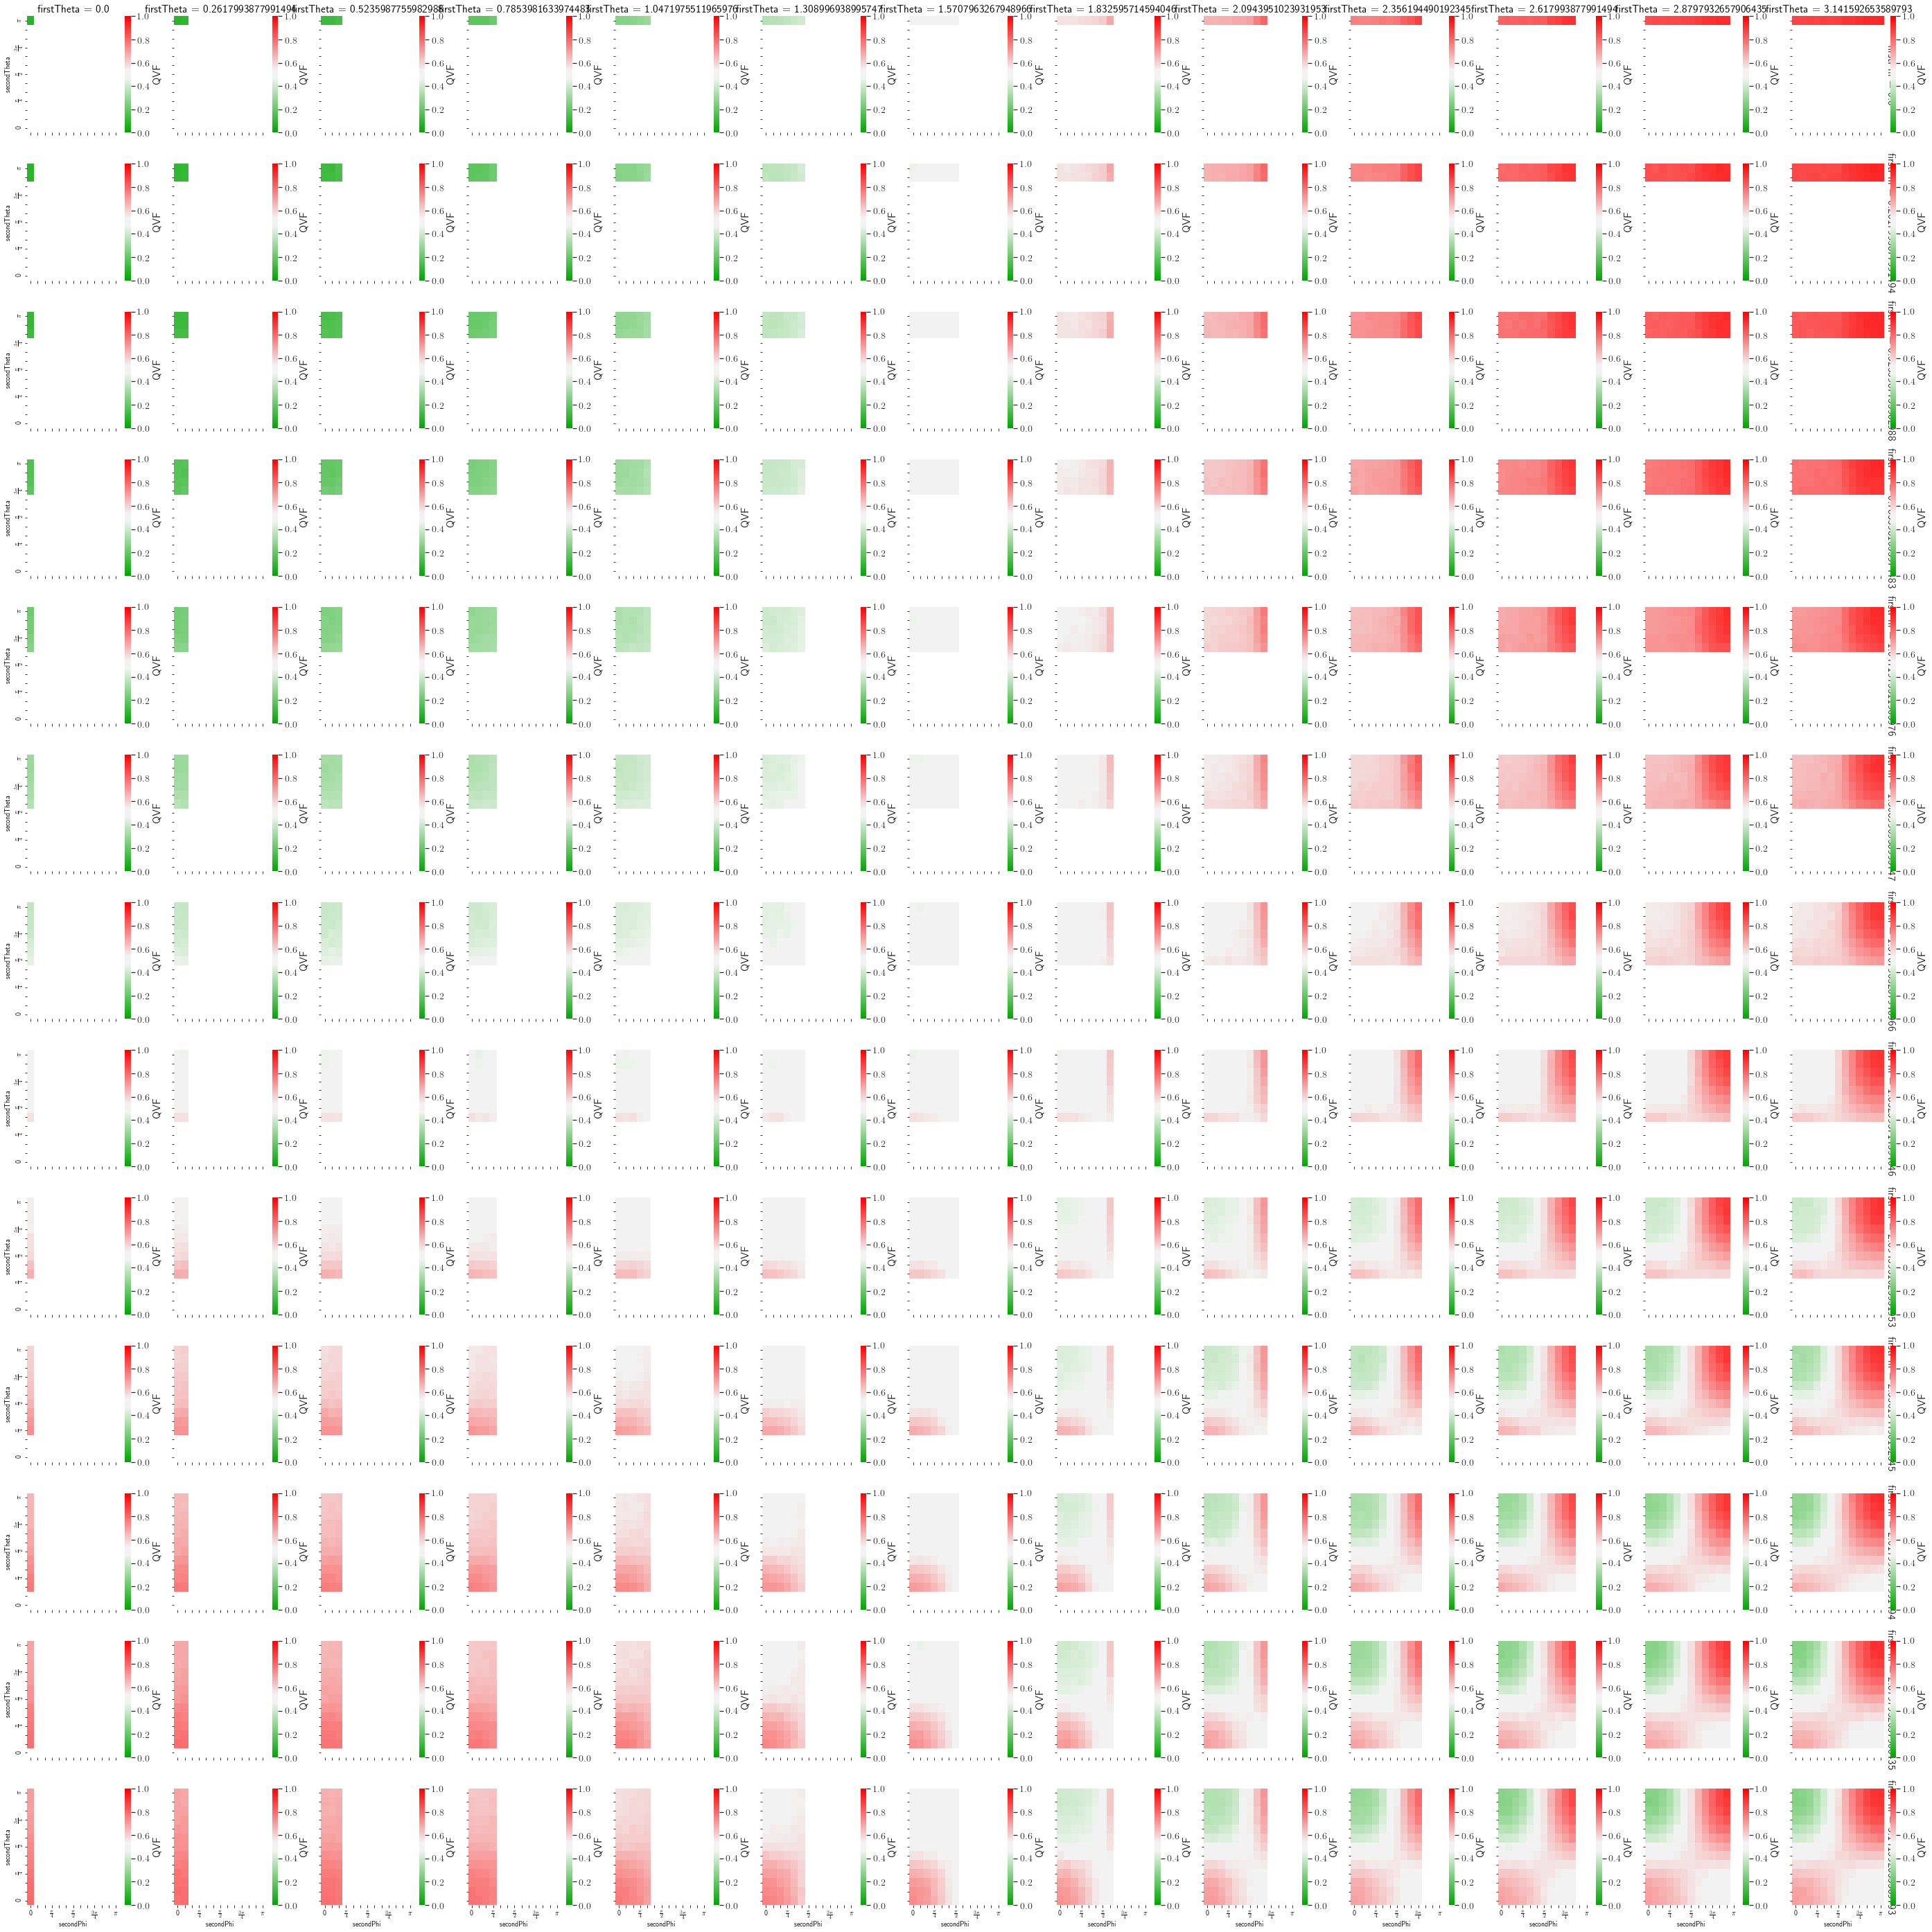

In [12]:

# ##considering only phi angles up to pi
# theta_list_tex = ['0', '', '', '$\\frac{\pi}{4}$', '', '',
#                   '$\\frac{\pi}{2}$', '', '', '$\\frac{3\pi}{4}$', '', '', '$\pi$']
# phi_list_tex = ['$\pi$', '', '',  '$\\frac{3\pi}{4}$', '', '',
#                 '$\\frac{\pi}{2}$', '', '', '$\\frac{\pi}{4}$', '', '', '0']


# def my_heatmap_plot(*args, **kwargs):
#     # data = kwargs.pop('data')
#     # d = data.pivot(index=args[1], columns=args[0], values=args[2])
#     # sns.heatmap(d, **kwargs)

#     qvf_tmp = new_qvfDF_noise[(new_qvfDF_noise['circuit_name'] == circuit) & (
#         new_qvfDF_noise['first_phi'] == phi_0) & (new_qvfDF_noise['first_theta'] == theta_0)]
#     qvf_tmp = qvf_tmp.pivot('second_phi', 'second_theta', 'QVF_circuit')
#     qvf_tmp.columns.name = '$\\theta$ shift'
#     qvf_tmp.index.name = '$\\phi$ shift'
#     # fig, ax = plt.subplots(1, 1, figsize=(6, 5))
#     param = {'label': 'QVF'}

#     divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
#     rdgn = sns.diverging_palette(
#         h_neg=130, h_pos=10, s=200, l=55, sep=20, as_cmap=True)
#     sns.set(font_scale=1.3)
#     ax = sns.heatmap(qvf_tmp, xticklabels=theta_list_tex,
#                      yticklabels=phi_list_tex, cmap=rdgn, cbar_kws=param, vmin=0, vmax=1)
#     # fig.savefig(dirHeatmapPlots+circuit+'_th_0_'+str(theta_0)+'_ph_0_' +
#     #             str(phi_0)+'_'+qvf_idx + '_heatmap.pdf', bbox_inches='tight')
#     # plt.close()

# g = sns.FacetGrid(new_qvfDF_noise, row="first_phi", col="first_theta", margin_titles=True)
# g.map(my_heatmap_plot,"second_phi", "second_theta")


##considering only phi angles up to pi
theta_list_tex = ['0', '', '', '$\\frac{\pi}{4}$', '', '',
                  '$\\frac{\pi}{2}$', '', '', '$\\frac{3\pi}{4}$', '', '', '$\pi$']
phi_list_tex = ['$\pi$', '', '',  '$\\frac{3\pi}{4}$', '', '',
                '$\\frac{\pi}{2}$', '', '', '$\\frac{\pi}{4}$', '', '', '0']

### plotting collage of qvf heatmaps
def my_heatmap_plot(*args, **kwargs):
    # data = kwargs.pop('data')
    # d = data.pivot(index=args[1], columns=args[0], values=args[2])
    # sns.heatmap(d, **kwargs)

    pd_series_second_phi = args[0]
    pd_series_second_theta = args[1]
    pd_series_qvf = args[2]
    pd_dataframe = pd.DataFrame({
        pd_series_second_phi.name: pd_series_second_phi,
        pd_series_second_theta.name: pd_series_second_theta,
        pd_series_qvf.name: pd_series_qvf

    })

    pd_dataframe = pd_dataframe.pivot(
        pd_series_second_phi.name, pd_series_second_theta.name, pd_series_qvf.name)
    pd_dataframe.columns.name = '$\\theta$ shift'
    pd_dataframe.index.name = '$\\phi$ shift'

    #qvf_tmp = new_qvfDF_noise[(new_qvfDF_noise['circuitName'] == circuit) & (
    #new_qvfDF_noise['firstPhi'] == phi_0) & (new_qvfDF_noise['firstTheta'] == theta_0)]

    #qvf_tmp = qvf_tmp.pivot('secondPhi', 'secondTheta', 'QVFCircuit')

    #qvf_tmp.columns.name = '$\\theta$ shift'
    #qvf_tmp.index.name = '$\\phi$ shift'
    # fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    param = {'label': 'QVF'}

    divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
    rdgn = sns.diverging_palette(
        h_neg=130, h_pos=10, s=200, l=55, sep=20, as_cmap=True)
    sns.set(font_scale=1.3)

    ax = sns.heatmap(pd_dataframe, xticklabels=theta_list_tex,
                     yticklabels=phi_list_tex, cmap=rdgn, cbar_kws=param, vmin=0, vmax=1)
    # fig.savefig(dirHeatmapPlots+circuit+'_th_0_'+str(theta_0)+'_ph_0_' +
    #             str(phi_0)+'_'+qvf_idx + '_heatmap.pdf', bbox_inches='tight')
    # plt.close()



#new_qvfDF_noise = new_qvfDF_noise[:100000] #reduce for faster debug


for circuit in circuits:
    # get a list of qubit columns (circuit may have different number of qubits now)
    colNames = new_qvfDF_noise[new_qvfDF_noise['circuitName'] == circuit].dropna(
        axis=1).columns
    QVF_list = ['QVF_circuit']
    # uncomment this line to include individual qubit analysis
    QVF_list.extend([x for x in colNames if re.search('QVF_qubit_.*', x)])
    for qvf_idx in QVF_list:
        g = sns.FacetGrid(new_qvfDF_noise, row="firstPhi", col="firstTheta", margin_titles=True)
        g.map(my_heatmap_plot, "secondPhi", "secondTheta", qvf_idx)
        g.savefig('collage_'+circuit+'_'+qvf_idx+'.pdf')
